# CHEST X-RAY AI

### DATA LOADING

In [ ]:
from google.colab import files

# Upload kaggle.json file
files.upload()



Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"saratusalihu","key":"45fca87d60a3ca2a9ecc45fef4f0f8a7"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!pip install -q kaggle


In [ ]:
# Download and unzip the dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia --unzip -p ./dataset


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.27G/2.29G [00:22<00:00, 49.8MB/s]
100% 2.29G/2.29G [00:22<00:00, 109MB/s] 


In [ ]:
import os

base_dir = './dataset/chest_xray'

print("Train folders:", os.listdir(os.path.join(base_dir, 'train')))
print("Test folders:", os.listdir(os.path.join(base_dir, 'test')))


Train folders: ['PNEUMONIA', 'NORMAL']
Test folders: ['PNEUMONIA', 'NORMAL']


In [ ]:
import os
import shutil
import random

# Original dataset paths
original_base = './dataset/chest_xray'
train_dir = os.path.join(original_base, 'train')
test_dir = os.path.join(original_base, 'test')

# New small subset paths
subset_base = './dataset_small'
os.makedirs(subset_base, exist_ok=True)

def create_subset(split):
    for cls in ['PNEUMONIA', 'NORMAL']:
        orig_path = os.path.join(original_base, split, cls)
        subset_path = os.path.join(subset_base, split, cls)
        os.makedirs(subset_path, exist_ok=True)

        # Randomly pick 50 images per class
        images = os.listdir(orig_path)
        random.shuffle(images)
        selected = images[:50]

        for img in selected:
            shutil.copy(os.path.join(orig_path, img), os.path.join(subset_path, img))

# Create small train/test subsets
create_subset('train')
create_subset('test')

print("Small dataset created at './dataset_small'")


Small dataset created at './dataset_small'


In [ ]:
from google.colab import drive
import shutil
import os

#  Mount Google Drive
drive.mount('/content/drive')

# 2Set a path in Drive
drive_path = '/content/drive/MyDrive/Chest_Xray_Demo'

# 3 Copy the small dataset to Drive
if os.path.exists(drive_path):
    shutil.rmtree(drive_path)
shutil.copytree('./dataset_small', drive_path)

print(f"Small dataset saved to Google Drive at {drive_path}")

Mounted at /content/drive
Small dataset saved to Google Drive at /content/drive/MyDrive/Chest_Xray_Demo


APPLYING SVD FOR PREPROCESSING
We applied Singular value decompostion to compressed images and retain only the most important features,the reconstructed svd picture will be fed to simple CNN classifier,this approach help us reduced the depth of the CNN layers and provide a lightweidht model suitable for resource constraint areas without compromising the model performance

In [ ]:
import os
import cv2
import numpy as np
from glob import glob
from sklearn.utils import shuffle


In [ ]:
def svd_compress_image(image_path, k=50, resize=(224,224)):
    """
    Load an image, convert to grayscale, resize, apply SVD compression, and reconstruct.
    """
    # Load and resize
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, resize)

    # Apply SVD
    U, S, Vt = np.linalg.svd(img, full_matrices=False)
    S_k = np.diag(S[:k])
    U_k = U[:, :k]
    Vt_k = Vt[:k, :]
    img_reconstructed = np.dot(U_k, np.dot(S_k, Vt_k))

    # Normalize to 0-1
    img_reconstructed = img_reconstructed / 255.0
    img_reconstructed = np.expand_dims(img_reconstructed, axis=-1)  # add channel
    return img_reconstructed


In [ ]:
def prepare_dataset(base_path):
    X, y = [], []
    for label, cls in enumerate(['NORMAL', 'PNEUMONIA']):
        folder = os.path.join(base_path, cls)
        images = glob(os.path.join(folder, '*'))
        for img_path in images:
            img = svd_compress_image(img_path, k=50)
            X.append(img)
            y.append(label)
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.int32)
    X, y = shuffle(X, y, random_state=42)
    return X, y

# Prepare train and test
train_path = '/content/drive/MyDrive/Chest_Xray_Demo/train'
test_path = '/content/drive/MyDrive/Chest_Xray_Demo/test'

X_train, y_train = prepare_dataset(train_path)
X_test, y_test = prepare_dataset(test_path)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (100, 224, 224, 1), Test shape: (100, 224, 224, 1)


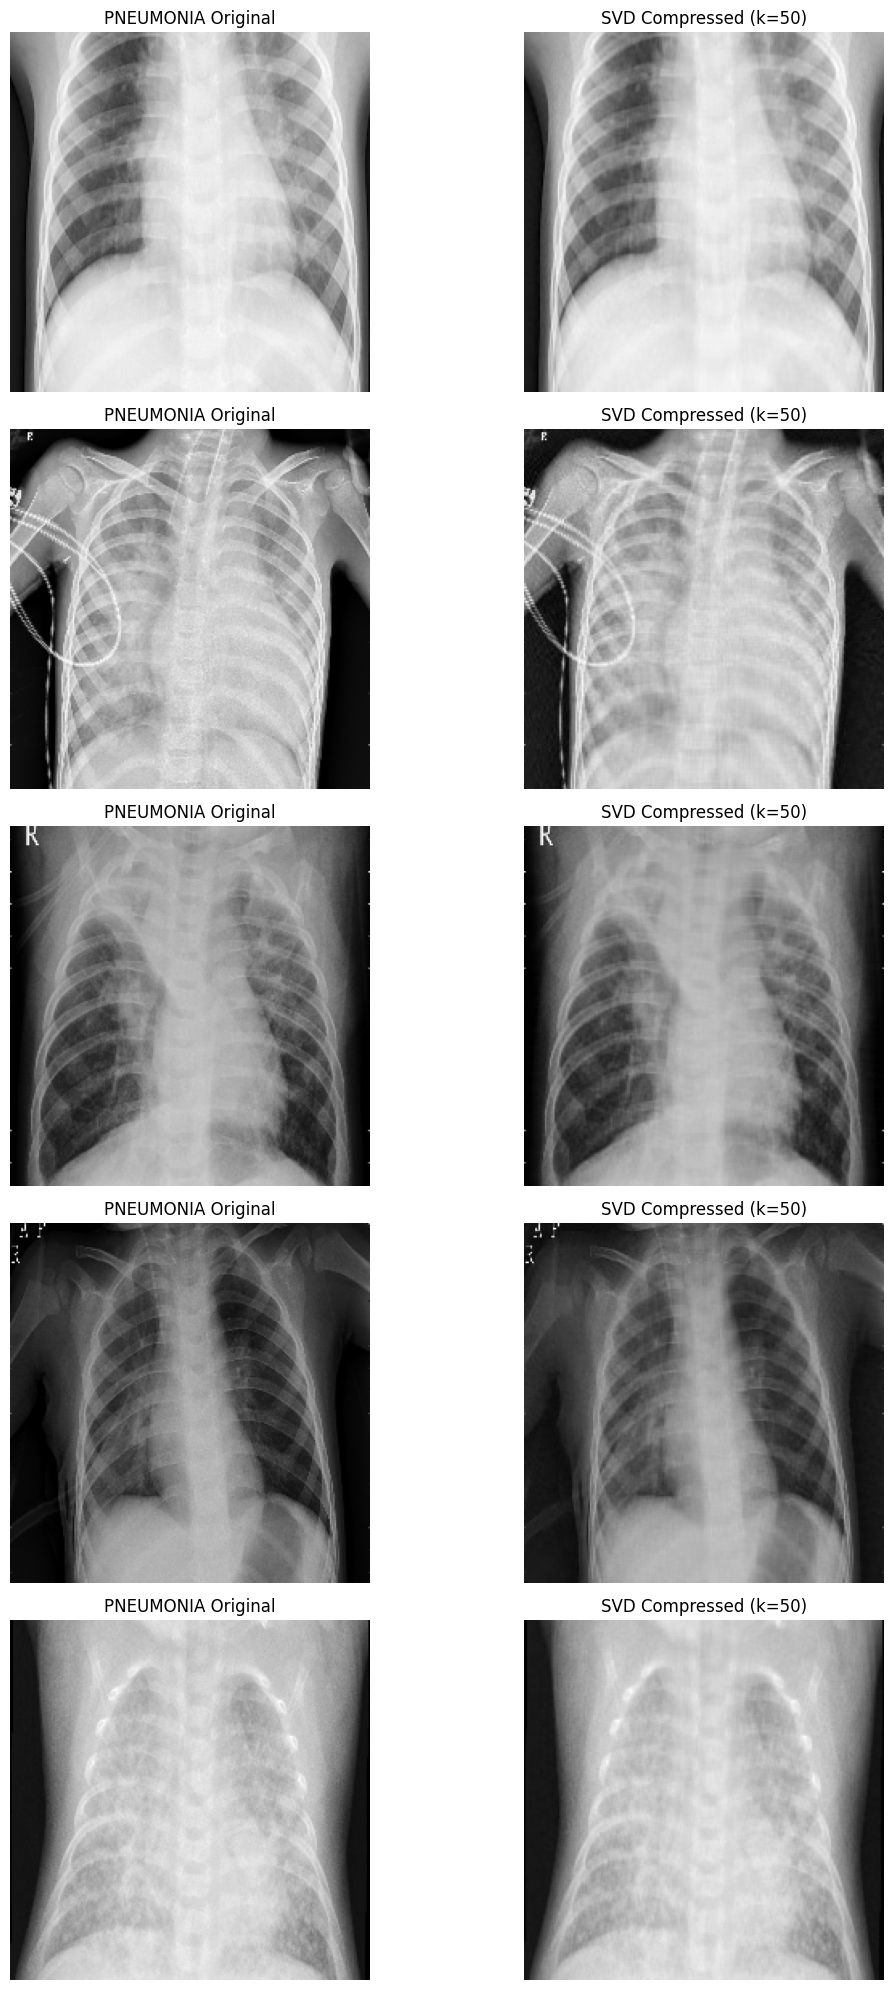

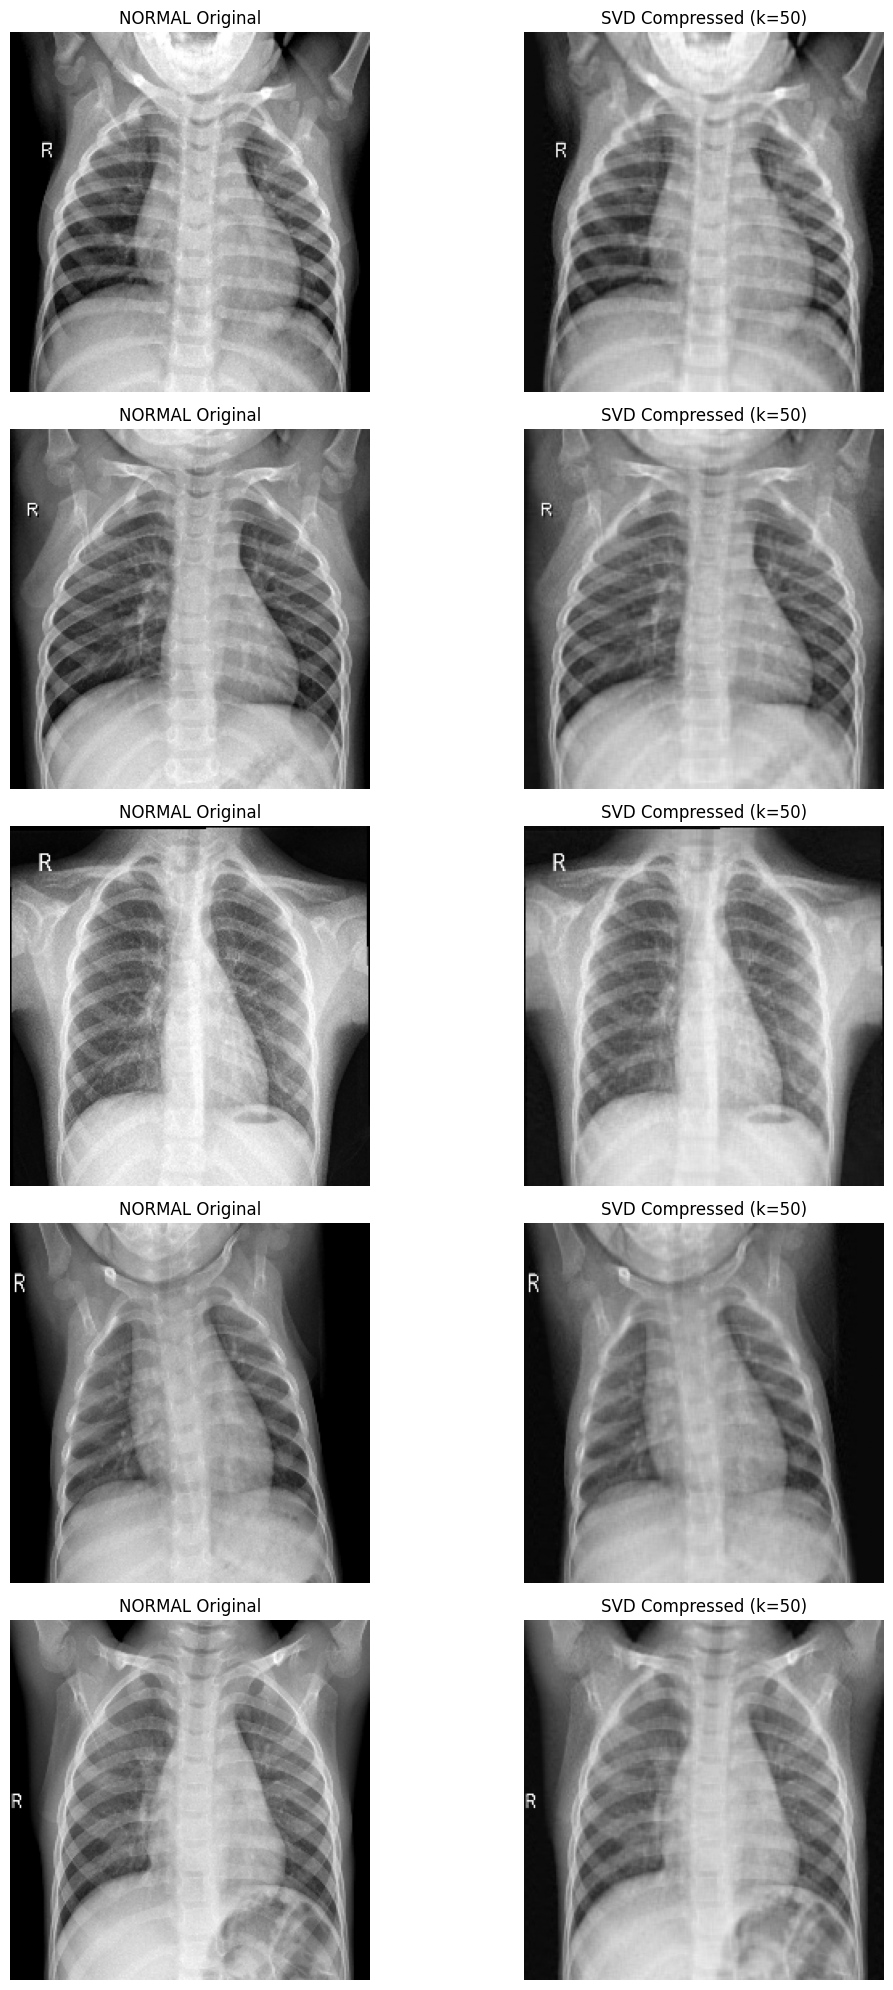

In [ ]:
import matplotlib.pyplot as plt
def visualize_grid(class_name='PNEUMONIA', num_images=5, k=50):

    # Visualize original and SVD-compressed images for a given class.

    images = glob(os.path.join(train_path, class_name, '*'))
    selected = random.sample(images, num_images)

    plt.figure(figsize=(12, 4 * num_images))

    for i, img_path in enumerate(selected):
        # Original
        orig = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        orig = cv2.resize(orig, (224,224))

        # SVD
        svd_img = svd_compress_image(img_path, k=k, resize=(224,224)).squeeze()

        # Plot Original
        plt.subplot(num_images, 2, i*2 + 1)
        plt.imshow(orig, cmap='gray')
        plt.title(f'{class_name} Original')
        plt.axis('off')

        # Plot SVD
        plt.subplot(num_images, 2, i*2 + 2)
        plt.imshow(svd_img, cmap='gray')
        plt.title(f'SVD Compressed (k={k})')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example: visualize 5 images from PNEUMONIA and NORMAL
visualize_grid('PNEUMONIA', num_images=5, k=50)
visualize_grid('NORMAL', num_images=5, k=50)


CNN MODEL CLASSIFIER

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical


In [ ]:
# Convert labels to categorical
y_train_cat = to_categorical(y_train, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train_cat.shape)


X_train shape: (100, 224, 224, 1)
y_train shape: (100, 2)


In [ ]:
def build_cnn(input_shape=(224,224,1), num_classes=2):
    model = models.Sequential()

    # Conv Block 1
    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2,2)))

    # Conv Block 2
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))

    # Conv Block 3
    model.add(layers.Conv2D(128, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))

    # Flatten + Dense
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Build the model
model = build_cnn()
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,168,642 (42.60 MB)

 Trainable params: 11,168,642 (42.60 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train
history = model.fit(
    X_train, y_train_cat,
    epochs=10,
    batch_size=16,
    validation_data=(X_test, y_test_cat)
)


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5800 - loss: 1.1028 - val_accuracy: 0.5000 - val_loss: 0.6907
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.5491 - loss: 0.6840 - val_accuracy: 0.8500 - val_loss: 0.6624
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.5780 - loss: 0.6568 - val_accuracy: 0.5000 - val_loss: 0.8276
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6153 - loss: 0.6795 - val_accuracy: 0.8800 - val_loss: 0.4590
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7634 - loss: 0.4623 - val_accuracy: 0.8900 - val_loss: 0.3476
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8638 - loss: 0.3619 - val_accuracy: 0.7200 - val_loss: 0.5083
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8821 - loss: 0.2979 - val_accuracy: 0.7300 - val_loss: 0.5663
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8941 - loss: 0.2676 - val_accuracy: 0.7400 - val_loss: 0.5145


# MODEL EVALUATION

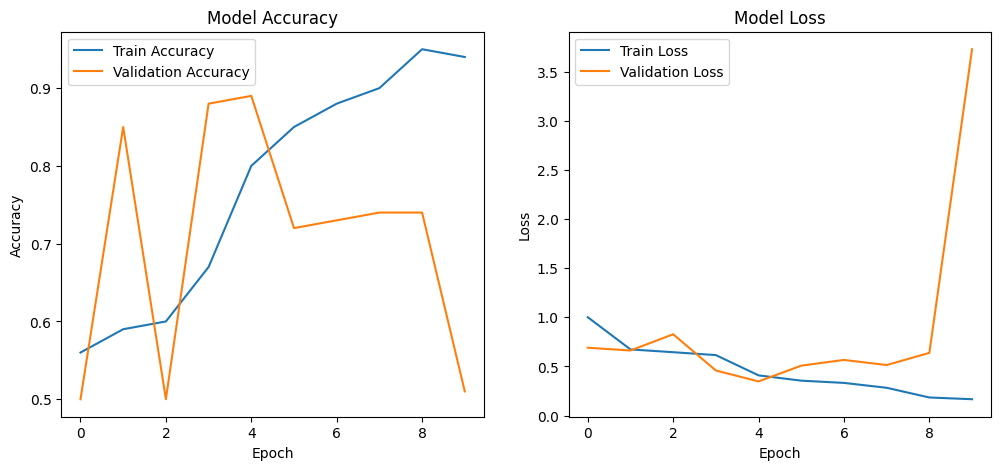

In [ ]:
# Plot training & validation accuracy
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step


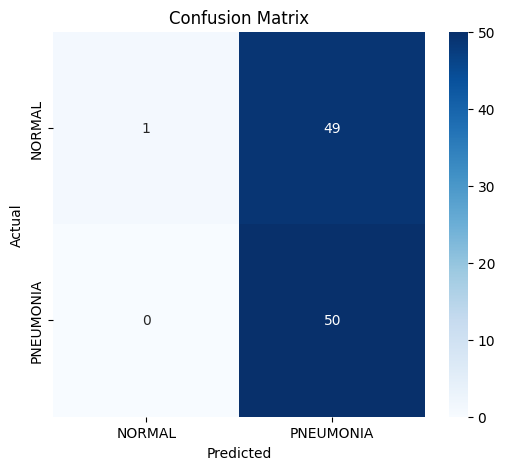

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Predict classes
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['NORMAL', 'PNEUMONIA'],
            yticklabels=['NORMAL', 'PNEUMONIA'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred_classes, target_names=['NORMAL', 'PNEUMONIA'])
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

      NORMAL       1.00      0.02      0.04        50
   PNEUMONIA       0.51      1.00      0.67        50

    accuracy                           0.51       100
   macro avg       0.75      0.51      0.36       100
weighted avg       0.75      0.51      0.36       100

